Synthetic X shape: (2500, 10)   #true clusters: 5


C:\Users\Samantha\anaconda3\Lib\site-packages\sklearn\manifold\_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
C:\Users\Samantha\anaconda3\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Samantha\anaconda3\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\Samantha\anaconda3\Lib\site-packages\scipy\sparse\_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
C:\Users\

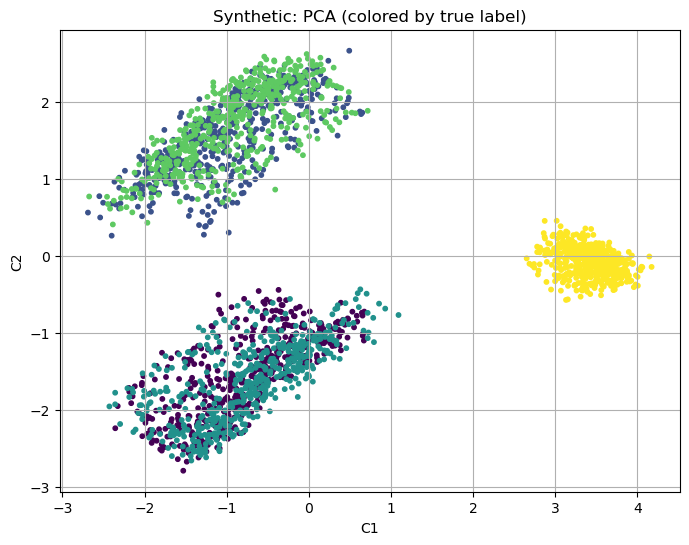

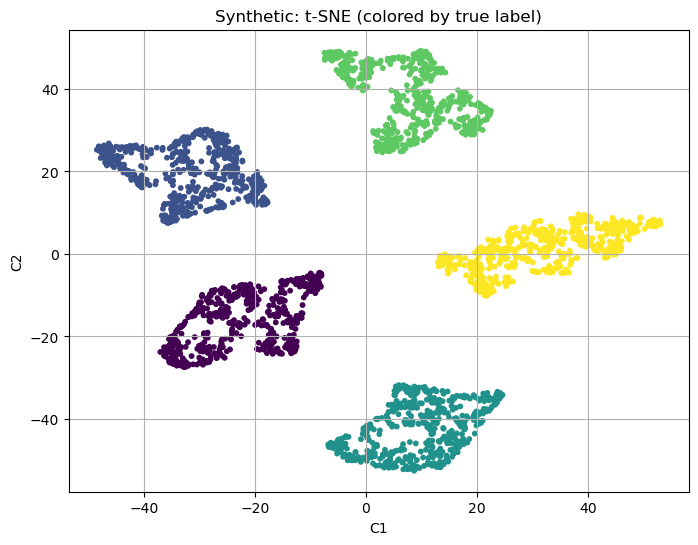

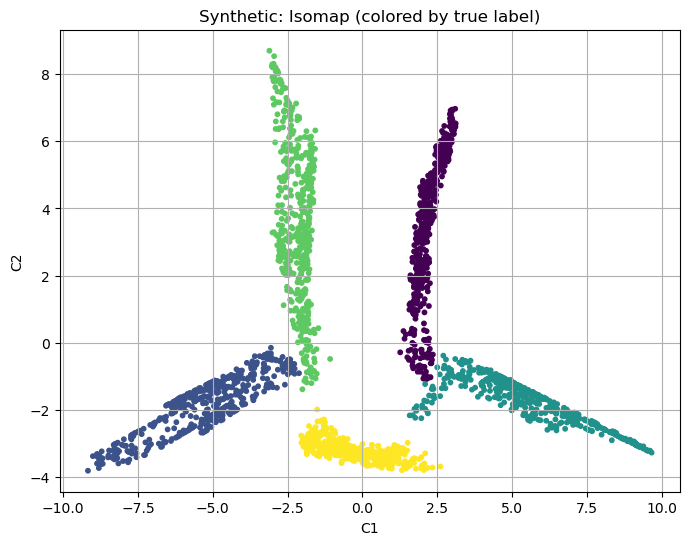


method      space     clusters   sil        ari
-------------------------------------------------
kmeans     raw             5    0.4876    1.0000
dbscan     raw             6    0.3529    0.9808
kmeans     PCA             5    0.5842    0.5031
dbscan     PCA             3    0.7300    0.6150
kmeans     TSNE            5    0.6644    1.0000
dbscan     TSNE            2   -0.3428    0.0001
kmeans     Isomap          5    0.5744    0.8384
dbscan     Isomap          3    0.3659    0.6150


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

np.random.seed(0)

# 1) define nonlinear map f: R^2 -> R^10 
def f_map(UV):
    u = UV[:,0]
    v = UV[:,1]
    X = np.column_stack([
        u,
        v,
        np.sin(u),
        np.cos(v),
        np.sin(u*v),
        u**2,
        v**2,
        np.exp(-0.5*(u**2+v**2)),
        np.sin(2*u) + np.cos(2*v),
        u*v
    ])
    return X

# 2) generate 3-6 patches in (u,v) 
patch_specs = [
    (-3.0, -1.5, -3.0, -1.5),
    ( 1.5,  3.0, -3.0, -1.5),
    (-3.0, -1.5,  1.5,  3.0),
    ( 1.5,  3.0,  1.5,  3.0),
    (-0.7,  0.7, -0.7,  0.7)
]
n_per_patch = 500
sigma_noise = 0.10

UV_list = []
ytrue_list = []
for j, (umin, umax, vmin, vmax) in enumerate(patch_specs):
    u = np.random.uniform(umin, umax, size=n_per_patch)
    v = np.random.uniform(vmin, vmax, size=n_per_patch)
    UV = np.column_stack([u, v])
    UV_list.append(UV)
    ytrue_list.append(np.full(n_per_patch, j, dtype=int))

UV = np.vstack(UV_list)
ytrue = np.concatenate(ytrue_list)

X10 = f_map(UV)
X10 = X10 + sigma_noise*np.random.randn(*X10.shape)

print("Synthetic X shape:", X10.shape, "  #true clusters:", len(np.unique(ytrue)))

# 3) standardize + embeddings 
scaler = StandardScaler()
X10s = scaler.fit_transform(X10)

Z_pca = PCA(n_components=2, random_state=0).fit_transform(X10s)
Z_tsne = TSNE(n_components=2, perplexity=40, init="pca", learning_rate="auto", random_state=0).fit_transform(X10s)
Z_iso = Isomap(n_components=2, n_neighbors=20).fit_transform(X10s)

# 4) plot embeddings colored by true labels
plt.figure(figsize=(8,6))
plt.scatter(Z_pca[:,0], Z_pca[:,1], c=ytrue, s=10)
plt.title("Synthetic: PCA (colored by true label)")
plt.xlabel("C1"); plt.ylabel("C2"); plt.grid(True); plt.show()

plt.figure(figsize=(8,6))
plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=ytrue, s=10)
plt.title("Synthetic: t-SNE (colored by true label)")
plt.xlabel("C1"); plt.ylabel("C2"); plt.grid(True); plt.show()

plt.figure(figsize=(8,6))
plt.scatter(Z_iso[:,0], Z_iso[:,1], c=ytrue, s=10)
plt.title("Synthetic: Isomap (colored by true label)")
plt.xlabel("C1"); plt.ylabel("C2"); plt.grid(True); plt.show()

# 5) clustering on raw 10D ,ARI 
def get_sil(X, yhat):
    labs = set(yhat)
    if len(labs) < 2 or labs == {-1}:
        return np.nan
    try:
        return silhouette_score(X, yhat)
    except:
        return np.nan

k = len(np.unique(ytrue))

print("\nmethod      space     clusters   sil        ari")
print("-------------------------------------------------")

# raw
yhat = KMeans(n_clusters=k, n_init=20, random_state=0).fit_predict(X10s)
print("{:10s} {:8s} {:8d} {:9.4f} {:9.4f}".format("kmeans", "raw", len(set(yhat)), get_sil(X10s,yhat), adjusted_rand_score(ytrue,yhat)))

yhat = DBSCAN(eps=0.7, min_samples=10).fit_predict(X10s)
nclu = len(set(yhat)) - (1 if -1 in set(yhat) else 0)
print("{:10s} {:8s} {:8d} {:9.4f} {:9.4f}".format("dbscan", "raw", nclu, get_sil(X10s,yhat), adjusted_rand_score(ytrue,yhat)))

# PCA
yhat = KMeans(n_clusters=k, n_init=20, random_state=0).fit_predict(Z_pca)
print("{:10s} {:8s} {:8d} {:9.4f} {:9.4f}".format("kmeans", "PCA", len(set(yhat)), get_sil(Z_pca,yhat), adjusted_rand_score(ytrue,yhat)))

yhat = DBSCAN(eps=0.7, min_samples=10).fit_predict(Z_pca)
nclu = len(set(yhat)) - (1 if -1 in set(yhat) else 0)
print("{:10s} {:8s} {:8d} {:9.4f} {:9.4f}".format("dbscan", "PCA", nclu, get_sil(Z_pca,yhat), adjusted_rand_score(ytrue,yhat)))

# t-SNE
yhat = KMeans(n_clusters=k, n_init=20, random_state=0).fit_predict(Z_tsne)
print("{:10s} {:8s} {:8d} {:9.4f} {:9.4f}".format("kmeans", "TSNE", len(set(yhat)), get_sil(Z_tsne,yhat), adjusted_rand_score(ytrue,yhat)))

yhat = DBSCAN(eps=0.7, min_samples=10).fit_predict(Z_tsne)
nclu = len(set(yhat)) - (1 if -1 in set(yhat) else 0)
print("{:10s} {:8s} {:8d} {:9.4f} {:9.4f}".format("dbscan", "TSNE", nclu, get_sil(Z_tsne,yhat), adjusted_rand_score(ytrue,yhat)))

# Isomap
yhat = KMeans(n_clusters=k, n_init=20, random_state=0).fit_predict(Z_iso)
print("{:10s} {:8s} {:8d} {:9.4f} {:9.4f}".format("kmeans", "Isomap", len(set(yhat)), get_sil(Z_iso,yhat), adjusted_rand_score(ytrue,yhat)))

yhat = DBSCAN(eps=0.7, min_samples=10).fit_predict(Z_iso)
nclu = len(set(yhat)) - (1 if -1 in set(yhat) else 0)
print("{:10s} {:8s} {:8d} {:9.4f} {:9.4f}".format("dbscan", "Isomap", nclu, get_sil(Z_iso,yhat), adjusted_rand_score(ytrue,yhat)))


Wine shape: (6497, 13)


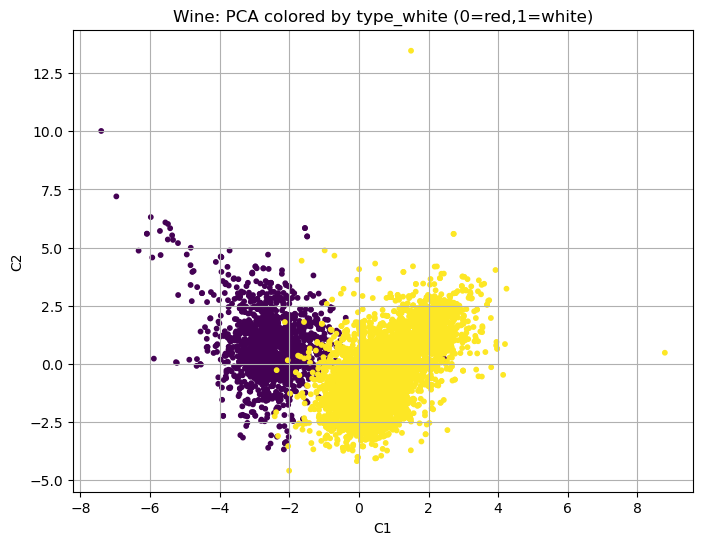

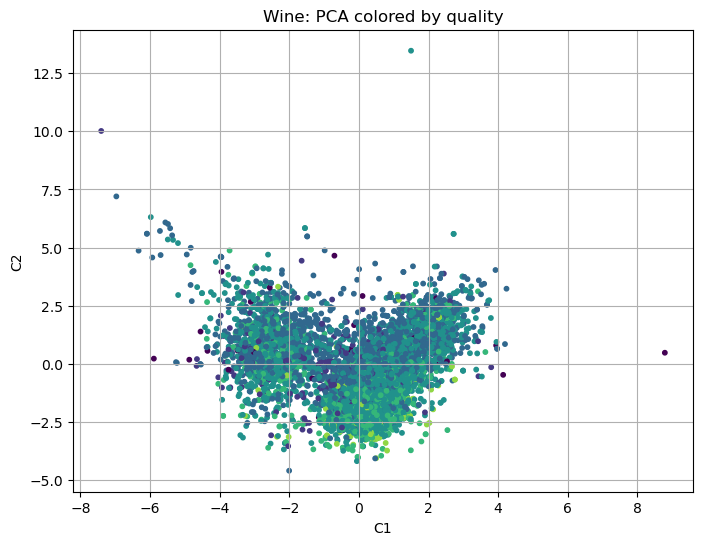

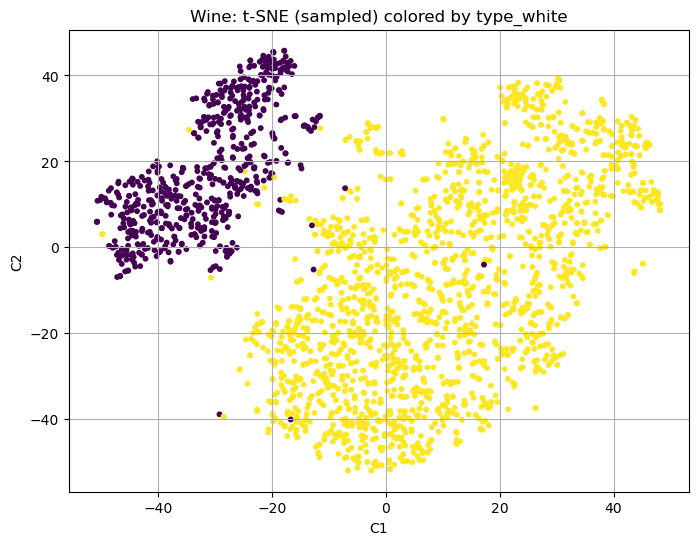

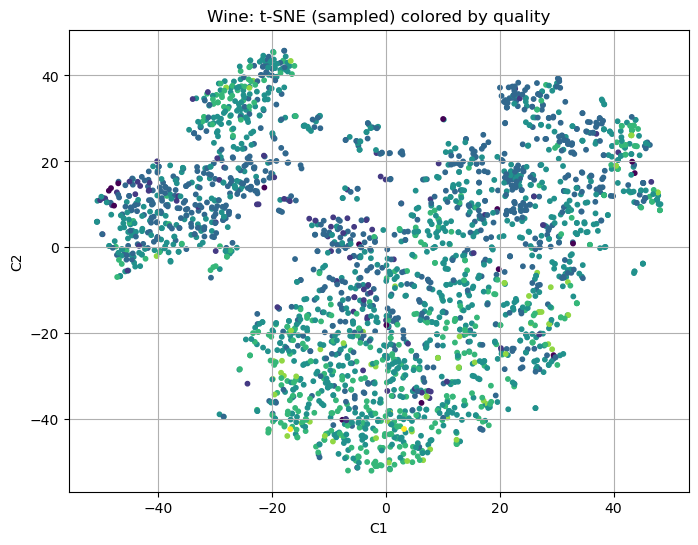


=== Clustering vs type_white (k=2) ===
method      space     clusters   sil        ari
-------------------------------------------------
kmeans     raw             2    0.2766    0.9417
dbscan     raw            21   -0.4138   -0.0218
kmeans     PCA             2    0.4632    0.9284
dbscan     PCA             2    0.5638    0.0131
kmeans     TSNE            2    0.4153    0.8678
dbscan     TSNE            0       nan    0.0000

=== Clustering vs regrouped quality (3 bins) ===
method      space     clusters   sil        ari
-------------------------------------------------
kmeans     raw             3    0.2351    0.0229
dbscan     raw            21   -0.4138    0.0020
kmeans     PCA             3    0.4931    0.0236
dbscan     PCA             2    0.5638   -0.0005
kmeans     TSNE            3    0.5091    0.0324
dbscan     TSNE            0       nan    0.0000


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

np.random.seed(0)

# 1) load data (semicolon-separated) + add type_white
red = pd.read_csv("winequality-red.csv", sep=";")
white = pd.read_csv("winequality-white.csv", sep=";")

red["type_white"] = 0
white["type_white"] = 1

wine = pd.concat([red, white], ignore_index=True)
print("Wine shape:", wine.shape)

# 2) standardize features 
feature_cols = [c for c in wine.columns if c not in ["quality", "type_white"]]
X = wine[feature_cols].values

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

y_type = wine["type_white"].values
y_q = wine["quality"].values

# regroup quality into 3 bins (optional but helpful for clustering comparison)
y_q3 = np.where(y_q <= 5, 0, np.where(y_q == 6, 1, 2))

# 3) embeddings 
Z_pca = PCA(n_components=2, random_state=0).fit_transform(Xs)

n = len(wine)
m = 2500  # sample size for t-SNE (keeps it fast so plots show)
idx = np.random.choice(n, size=m, replace=False)

Z_tsne = TSNE(n_components=2, perplexity=40, init="pca",
              learning_rate="auto", random_state=0).fit_transform(Xs[idx])

# 4) plots
plt.figure(figsize=(8,6))
plt.scatter(Z_pca[:,0], Z_pca[:,1], c=y_type, s=10)
plt.title("Wine: PCA colored by type_white (0=red,1=white)")
plt.xlabel("C1"); plt.ylabel("C2"); plt.grid(True); plt.show()

plt.figure(figsize=(8,6))
plt.scatter(Z_pca[:,0], Z_pca[:,1], c=y_q, s=10)
plt.title("Wine: PCA colored by quality")
plt.xlabel("C1"); plt.ylabel("C2"); plt.grid(True); plt.show()

plt.figure(figsize=(8,6))
plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=y_type[idx], s=10)
plt.title("Wine: t-SNE (sampled) colored by type_white")
plt.xlabel("C1"); plt.ylabel("C2"); plt.grid(True); plt.show()

plt.figure(figsize=(8,6))
plt.scatter(Z_tsne[:,0], Z_tsne[:,1], c=y_q[idx], s=10)
plt.title("Wine: t-SNE (sampled) colored by quality")
plt.xlabel("C1"); plt.ylabel("C2"); plt.grid(True); plt.show()

# 5) clustering helpers 
def get_sil(X, yhat):
    labs = set(yhat)
    if len(labs) < 2 or labs == {-1}:
        return np.nan
    try:
        return silhouette_score(X, yhat)
    except:
        return np.nan

def print_row(method, space, yhat, ytrue, X_for_sil):
    nclu = len(set(yhat)) - (1 if -1 in set(yhat) else 0)
    sil = get_sil(X_for_sil, yhat)
    ari = adjusted_rand_score(ytrue, yhat)
    print("{:10s} {:8s} {:8d} {:9.4f} {:9.4f}".format(method, space, nclu, sil, ari))

# 6) clustering vs type_white (k=2) 
print("\n=== Clustering vs type_white (k=2) ===")
print("method      space     clusters   sil        ari")
print("-------------------------------------------------")

# raw
yhat = KMeans(n_clusters=2, n_init=20, random_state=0).fit_predict(Xs)
print_row("kmeans", "raw", yhat, y_type, Xs)

yhat = DBSCAN(eps=0.8, min_samples=12).fit_predict(Xs)
print_row("dbscan", "raw", yhat, y_type, Xs)

# PCA
yhat = KMeans(n_clusters=2, n_init=20, random_state=0).fit_predict(Z_pca)
print_row("kmeans", "PCA", yhat, y_type, Z_pca)

yhat = DBSCAN(eps=0.8, min_samples=12).fit_predict(Z_pca)
print_row("dbscan", "PCA", yhat, y_type, Z_pca)

# t-SNE (sampled)
yhat = KMeans(n_clusters=2, n_init=20, random_state=0).fit_predict(Z_tsne)
print_row("kmeans", "TSNE", yhat, y_type[idx], Z_tsne)

yhat = DBSCAN(eps=0.8, min_samples=12).fit_predict(Z_tsne)
print_row("dbscan", "TSNE", yhat, y_type[idx], Z_tsne)

# 7) clustering vs quality (3 bins)
print("\n=== Clustering vs regrouped quality (3 bins) ===")
print("method      space     clusters   sil        ari")
print("-------------------------------------------------")

# raw
yhat = KMeans(n_clusters=3, n_init=20, random_state=0).fit_predict(Xs)
print_row("kmeans", "raw", yhat, y_q3, Xs)

yhat = DBSCAN(eps=0.8, min_samples=12).fit_predict(Xs)
print_row("dbscan", "raw", yhat, y_q3, Xs)

# PCA
yhat = KMeans(n_clusters=3, n_init=20, random_state=0).fit_predict(Z_pca)
print_row("kmeans", "PCA", yhat, y_q3, Z_pca)

yhat = DBSCAN(eps=0.8, min_samples=12).fit_predict(Z_pca)
print_row("dbscan", "PCA", yhat, y_q3, Z_pca)

# t-SNE (sampled)
yhat = KMeans(n_clusters=3, n_init=20, random_state=0).fit_predict(Z_tsne)
print_row("kmeans", "TSNE", yhat, y_q3[idx], Z_tsne)

yhat = DBSCAN(eps=0.8, min_samples=12).fit_predict(Z_tsne)
print_row("dbscan", "TSNE", yhat, y_q3[idx], Z_tsne)
